In [9]:
##Import packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [10]:
##Import data:
weather_train=pd.read_csv('data/weather_train.csv')
weather_test=pd.read_csv('data/weather_test.csv')
test=pd.read_csv('data/test.csv')
train=pd.read_csv('data/train.csv')
sample_submission=pd.read_csv('data/sample_submission.csv')
building_metadata=pd.read_csv('data/building_metadata.csv')
print("Import done")

Import done


In [11]:
##Merge into one dataframe:
df=train.merge(building_metadata)
df=df.merge(weather_train)
df['timestamp'] = pd.to_datetime(df['timestamp'])
print("Merge done")

Merge done


In [12]:
##New features:
#Time:
df['hour']=df.timestamp.dt.hour
df['month']=df.timestamp.dt.month
df['year']=df.timestamp.dt.year
df['day']=df.timestamp.dt.weekday
df['weekend'] = np.where((df['day'] == 5) | (df['day'] == 6), 1, 0)
print("Feature engineering done")

Feature engineering done


In [13]:
##One-hot encoding:
#Meter:
df = pd.get_dummies(df, columns=['meter'])
#Primary-use:
categorical_feature_mask = df.dtypes==object
categorical_cols = df.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))
df = pd.get_dummies(df, columns=['primary_use'])
print("One-hot encoding done")

One-hot encoding done


In [23]:
##Missing values:
print('Missing values for the dataset (in %)\n ')
print(df.isnull().sum())

Missing values for the train dataset (in %)
 
building_id                  0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12113306
floor_count           16630052
air_temperature           6163
cloud_coverage         8734870
dew_temperature           9645
precip_depth_1_hr      3658528
sea_level_pressure     1141174
wind_direction         1358553
wind_speed               53181
hour                         0
month                        0
year                         0
day                          0
weekend                      0
meter_0                      0
meter_1                      0
meter_2                      0
meter_3                      0
dtype: int64


In [24]:
##Handling missing data:

#Removing features with missing values for more than 30% of the dataset
dropped_features=["cloud_coverage","precip_depth_1_hr","year_built","floor_count"]
for x in dropped_features:
    df=df.drop(columns=x)
    
#Replacing missing values with median:
replace_median=["sea_level_pressure","wind_direction","air_temperature","dew_temperature","wind_speed"]
for x in replace_median:
    df[x].fillna(df[x].median(), inplace=True)
    
print("Missing values handled")

In [36]:
##Dropping irrelevant features:
irrelevant=["timestamp","year"]
for x in irrelevant:
    df=df.drop(columns=x)

In [28]:
##Standarizing
real_values=["square_feet","wind_direction","wind_speed","air_temperature","sea_level_pressure","dew_temperature"]
for x in real_values:
    df[x]=(df[x]-df[x].min())/(df[x].max()-df[x].min())
df.head()
print("Standarizing done")

Standarizing done


In [35]:
##Reducing memory usage:

#Float
float_mask = df.dtypes==float
float_cols = df.columns[float_mask].tolist()
df[float_cols]=df[float_cols].apply(pd.to_numeric,downcast='float')

#Int
int_mask = df.dtypes==int
int_cols = df.columns[int_mask].tolist()
df[int_cols]=df[int_cols].apply(pd.to_numeric,downcast='unsigned')

print("Memory usage reduced")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 35 columns):
building_id           uint16
timestamp             datetime64[ns]
meter_reading         float32
site_id               uint8
square_feet           float32
air_temperature       float32
dew_temperature       float32
sea_level_pressure    float32
wind_direction        float32
wind_speed            float32
hour                  uint8
month                 uint8
year                  uint16
day                   uint8
weekend               uint8
meter_0               uint8
meter_1               uint8
meter_2               uint8
meter_3               uint8
primary_use_0         uint8
primary_use_1         uint8
primary_use_2         uint8
primary_use_3         uint8
primary_use_4         uint8
primary_use_5         uint8
primary_use_6         uint8
primary_use_7         uint8
primary_use_8         uint8
primary_use_9         uint8
primary_use_10        uint8
primary_use_11      

In [41]:
df.head()

,building_id,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour,...,primary_use_6,primary_use_7,primary_use_8,primary_use_9,primary_use_10,primary_use_11,primary_use_12,primary_use_13,primary_use_14,primary_use_15
0,0,0.0,0,0.008173,0.708279,0.900164,0.666235,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0,0.002786,0.708279,0.900164,0.666235,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0.0,0,0.005822,0.708279,0.900164,0.666235,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0.0,0,0.026754,0.708279,0.900164,0.666235,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0.0,0,0.132985,0.708279,0.900164,0.666235,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
##Transforming targeted value
df.meter_reading=np.log1p(df.meter_reading)

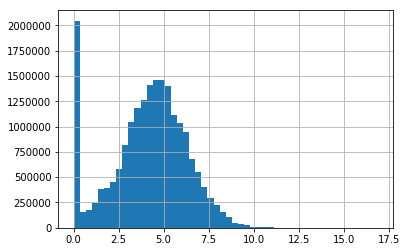

In [42]:
#Distribution of the log of targeted value:
df.meter_reading.hist(bins=50)

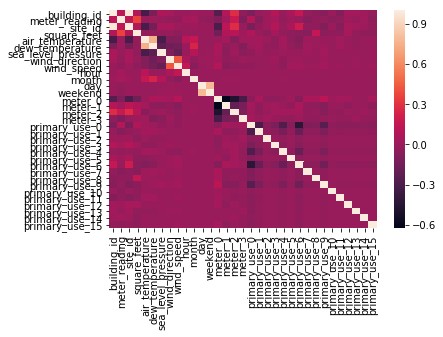

In [45]:
## Correlation matrix plot:
corr=df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
#Degeulasse! 

In [43]:
#Defining training data:
no_feature = ['building_id', 'timestamp', 'meter_reading', 'site_id']
X_train = df[df.columns.difference(no_feature)].copy(deep=False)
y_train = df['meter_reading']

In [44]:
X_train

,air_temperature,day,dew_temperature,hour,meter_0,meter_1,meter_2,meter_3,month,primary_use_0,...,primary_use_5,primary_use_6,primary_use_7,primary_use_8,primary_use_9,sea_level_pressure,square_feet,weekend,wind_direction,wind_speed
0,0.708279,4,0.900164,0,1,0,0,0,1,1,...,0,0,0,0,0,0.666235,0.008173,0,0.000000,0.000000
1,0.708279,4,0.900164,0,1,0,0,0,1,1,...,0,0,0,0,0,0.666235,0.002786,0,0.000000,0.000000
2,0.708279,4,0.900164,0,1,0,0,0,1,1,...,0,0,0,0,0,0.666235,0.005822,0,0.000000,0.000000
3,0.708279,4,0.900164,0,1,0,0,0,1,1,...,0,0,0,0,0,0.666235,0.026754,0,0.000000,0.000000
4,0.708279,4,0.900164,0,1,0,0,0,1,1,...,0,0,0,0,0,0.666235,0.132985,0,0.000000,0.000000
5,0.708279,4,0.900164,0,1,0,0,0,1,1,...,0,0,0,0,0,0.666235,0.008822,0,0.000000,0.000000
6,0.708279,4,0.900164,0,1,0,0,0,1,0,...,0,0,0,0,0,0.666235,0.031602,0,0.000000,0.000000
7,0.708279,4,0.900164,0,1,0,0,0,1,1,...,0,0,0,0,0,0.666235,0.138092,0,0.000000,0.000000
8,0.708279,4,0.900164,0,1,0,0,0,1,1,...,0,0,0,0,0,0.666235,0.069195,0,0.000000,0.000000
9,0.708279,4,0.900164,0,1,0,0,0,1,0,...,0,1,0,0,0,0.666235,0.030544,0,0.000000,0.000000
